Convert JSON to CSV

In [ ]:
# Since google restaurant dataset is in json format, use pandas to convert it into a CSV file
# DO NOT RERUN
import pandas as pd 
df = pd.read_json(r'E:\AIEBA Datasets\Proj1 Datasets\GoogleRestaurantReview.json', lines=True)
df.to_csv(r'E:\AIEBA Datasets\Proj1 Datasets\GoogleRestaurantReview.csv', index = None)

Formatting of Data

In [2]:
# Load in all three datasets
# .csv files use the utf-8 encoding
import pandas as pd

amzn = pd.read_csv(r'E:\AIEBA Datasets\Proj1 Datasets\AmazonReviews.csv',encoding='utf-8',engine='python')
googl = pd.read_csv(r'E:\AIEBA Datasets\Proj1 Datasets\GoogleRestaurantReview.csv',encoding='utf-8',engine='python')
dis = pd.read_csv(r'E:\AIEBA Datasets\Proj1 Datasets\DisneylandReviews.csv',encoding='utf-8',engine='python')

# amzn = pd.read_csv(r'C:\AIEBA Datasets\Proj1 Datasets\AmazonReviews.csv',encoding='utf-8',engine='python')
# googl = pd.read_csv(r'C:\AIEBA Datasets\Proj1 Datasets\GoogleRestaurantReview.csv',encoding='utf-8',engine='python')
# dis = pd.read_csv(r'C:\AIEBA Datasets\Proj1 Datasets\DisneylandReviews.csv',encoding='utf-8',engine='python')

In [ ]:
amzn.head()

In [ ]:
googl.head()

In [ ]:
dis.head()

In [3]:
# Drop columns that are not needed and standardize column names
amzn = amzn.filter(items=['reviews.rating', 'reviews.text'])
amzn = amzn.rename(columns={"reviews.rating":"reviews_rating", "reviews.text":"reviews_text"})

googl = googl.filter(items=['rating', 'review_text'])
googl = googl.rename(columns={"rating":"reviews_rating", "review_text":"reviews_text"})

dis = dis.filter(items=['Rating','Review_Text'])
dis = dis.rename(columns={"Rating":"reviews_rating", "Review_Text":"reviews_text"})

amzn.head()

,reviews_rating,reviews_text
0,5.0,This $product so far has not%&^# disappointed....
1,5.0,great for beginner or experienced person. Boug...
2,5.0,Inexpensive tablet for him to use and learn on...
3,4.0,I've had my Fire HD 8 two weeks now and I love...
4,5.0,I bought this for my grand daughter when she c...


In [4]:
# Concatenate all 3 datasets by column
combined = pd.concat([amzn, googl, dis], ignore_index=True)
combined

,reviews_rating,reviews_text
0,5.0,This $product so far has not%&^# disappointed....
1,5.0,great for beginner or experienced person. Boug...
2,5.0,Inexpensive tablet for him to use and learn on...
3,4.0,I've had my Fire HD 8 two weeks now and I love...
4,5.0,I bought this for my grand daughter when she c...
...,...,...
1125886,5.0,i went to disneyland paris in july 03 and thou...
1125887,5.0,2 adults and 1 child of 11 visited Disneyland ...
1125888,5.0,My eleven year old daughter and myself went to...
1125889,4.0,"This hotel, part of the Disneyland Paris compl..."


Data Cleansing and preprocessing

In [5]:
# remove rows with missing values
print(combined.isnull().sum())
combined = combined.dropna()


reviews_rating    55
reviews_text      16
dtype: int64


In [6]:
#missing values removed 
print(combined.isnull().sum())

reviews_rating    0
reviews_text      0
dtype: int64


In [7]:
# remove non alphanumeric values from reviews_text data rows while preserving whitespace
import re 

cleanup_re = re.compile('[^\w\s\.\,\!\?]') # match whitespaces, words and puctuations
def cleanup(sentence):
  sentence = str(sentence)
  sentence = cleanup_re.sub('',sentence).strip() # remove anything that is not within the match
  return sentence

combined["reviews_text"] = combined["reviews_text"].apply(cleanup)
  

<ipython-input-7-a339265f0f39>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined["reviews_text"] = combined["reviews_text"].apply(cleanup)


In [ ]:
combined.head()

2.0     30092
1.0     45080
3.0     69203
4.0    223066
5.0    758380
Name: reviews_rating, dtype: int64

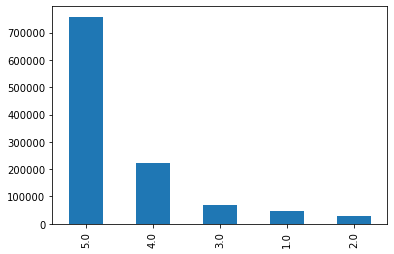

In [8]:
combined["reviews_rating"].value_counts().plot.bar()
combined["reviews_rating"].value_counts(ascending=True)

4.0    30092
3.0    30092
1.0    30092
2.0    30092
5.0    30092
Name: reviews_rating, dtype: int64

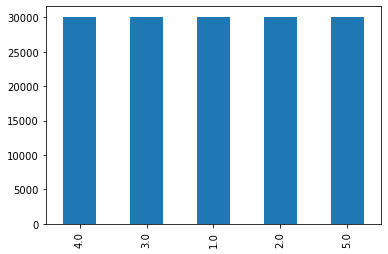

In [10]:
least_class_amount, class_1, class_3, class_4, class_5 = combined.reviews_rating.value_counts(ascending=True)

# create separate dataframes for each rating
c5 = combined[combined["reviews_rating"] == 5.0]
c4 = combined[combined["reviews_rating"] == 4.0]
c3 = combined[combined["reviews_rating"] == 3.0]
c2 = combined[combined["reviews_rating"] == 2.0]
c1 = combined[combined["reviews_rating"] == 1.0]

# randomly remove data to in each dataframe to match the number of rows in c2 which has the least amount of data
df_5 = c5.sample(least_class_amount, random_state=100)
df_4 = c4.sample(least_class_amount, random_state=100)
df_3 = c3.sample(least_class_amount, random_state=100)
df_1 = c1.sample(least_class_amount, random_state=100)

# concatenate all 5 dataframes into 1 to get a balanced dataset
undersampled = pd.concat([df_5, df_4, df_3, c2, df_1], axis=0)
combined = undersampled
combined.reviews_rating.value_counts().plot.bar()
combined.reviews_rating.value_counts()

In [11]:
# perform 80-20 split on data
from sklearn.model_selection import train_test_split
train, test = train_test_split(combined, test_size=0.2, train_size=0.8, random_state=100) 
# random_state controls how data is being shuffled
# ensures that data is being shuffled the same way every time the cell is being ran


In [ ]:
train.head()

Constructing the model

In [14]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

training_sentences = train["reviews_text"]
training_labels = train["reviews_rating"]
test_sentences = test["reviews_text"]
test_labels = test["reviews_rating"]
vocab_size = 97000 # number of words in the corpus/word index
embedding_dim = 5 # 
max_length = 100 #
trunc_type='post' # 
padding_type='post' #
oov_tok = "<OOV>" # placeholder if model encounters words it has never seen before in the test set

# Tokenization - breaking down sentences into its individual words and assigning a number to it
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index # Model's 'vocabulary' learnt from training data

# Sequencing - converting each sentence into its numerical equivalent
# Padding and truncating used to make all sentences same length 
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type,
                               truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type,
                               truncating=trunc_type)

In [15]:
# Need this block to get it to work with TensorFlow 2.x
training_padded = np.array(training_padded)
training_labels = tf.keras.utils.to_categorical(training_labels)
test_padded = np.array(test_padded)
test_labels = tf.keras.utils.to_categorical(test_labels)

Model Building

In [16]:
num_of_ratings = 5 # number of possible ratings given by users: 1 to 5

# Crating a model with 3 fully connected layers:
# 1 embedding layer to find correlation between words, 1 pooling layer, 1 layer with relu function 
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'), 
    tf.keras.layers.Dense(num_of_ratings, activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 8)            777216    
                                                                 
 global_average_pooling1d (G  (None, 8)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                216       
                                                                 
 dense_1 (Dense)             (None, 5)                 125       
                                                                 
Total params: 777,557
Trainable params: 777,557
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Running model with different epochs to compare outcome 

#epochs_1 = 10
#prediction_1 = model.fit(training_padded, training_labels, epochs=epochs_1, validation_data=(test_padded, test_labels), verbose=2)

epochs_2 = 10
prediction_2 = model.fit(training_padded, training_labels, epochs=epochs_2, validation_data=(test_padded, test_labels), verbose=2)

#epochs_3 = 30
#prediction_3 = model.fit(training_padded, training_labels, epochs=epochs_3, validation_data=(test_padded, test_labels), verbose=2)


# ERROR HERE IS CAUSED BY INPUT DIMENSIONS NOT BEING COMPATIBLE WITH OUTPUT DIMENSIONS,
# TODO: tune the values for the embedding layer 

Epoch 1/10


ValueError: in user code:

    File "e:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "e:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "e:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "e:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "e:\Anaconda3\lib\site-packages\keras\engine\training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "e:\Anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "e:\Anaconda3\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "e:\Anaconda3\lib\site-packages\keras\losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "e:\Anaconda3\lib\site-packages\keras\losses.py", line 2004, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "e:\Anaconda3\lib\site-packages\keras\backend.py", line 5532, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 6) and (None, 5) are incompatible


In [ ]:
sentence = ["Will never buy again"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
output= model.predict(padded)

print(output)
print("Review:", sentence)
print("Rating:", np.argmax(output, axis=None, out=None))